# The Bot Identity Analysis notebook

This notebook will be used to analyze the descriptions of the suspected-bot accounts and uncover the self-identity of these accounts. 

#### Disclaimer: Unfortunately, as all descriptions and usernames are personal data according to the GDPR, none of the output will be shown. It is discussed in the thesis itself. This notebook serves as a display of how the code has been used to sort and create

First, let's import the libraries that are used in this notebook

In [1]:
# Uncomment to install if not already
#!pip install pandas emoji nltk matplotlib spacy pyarrow

In [2]:
import pandas as pd # Used for data manipulation and analysis
import re # Used for regular expressions
import emoji # Used to get rid of emoji's
import nltk # Used for natural language processing, specifically stopwords
from nltk.corpus import stopwords # import stopwords from NLTK
from collections import Counter # Used to count
import matplotlib.pyplot as plt # Used for visualizations
import spacy # Also used for natural language processing, specifically PoS

In [3]:
# Here we import the gaswinning_sorted.feather file, which has been cleaned and sorted in a previous notebook
gaswinning = pd.read_feather("gaswinning_sorted.feather")

### Create a list of the most active bots with 5 or more occurances in the dataset

Since there are several descriptions per suspected-bot, in this case we pick the one which was the users' description in the most posts

In [4]:
# Create a bot_description dataframe containing the data to include only bots and relevant columns, dropping rows with missing descriptions
bot_descriptions = gaswinning.loc[gaswinning['BOT'] == True, ['user.id', 'user.description']].dropna(subset=["user.description"])

# Calculate the frequency of each bot's user ID, how many times have they appeared in the dataset
bot_activity = bot_descriptions['user.id'].value_counts()

# Create a dataframe that only contains the user id's of bots that occur 5 or more times in the dataset
active_bots = bot_activity[bot_activity >= 5].index

# Filter bot_descriptions dataframe to include only active bots
active_bot_descriptions = bot_descriptions[bot_descriptions['user.id'].isin(active_bots)]

# Some user's have had different bio's over the years, we analyze the unique one which has occured the most in the dataset
# Group by user ID and description to count occurrences of unique descriptions per account
description_counts = active_bot_descriptions.groupby(['user.id', 'user.description']).size().reset_index(name='count')

# Sort the counts in descending order to get the most bio's with the highest count on top
description_counts = description_counts.sort_values(by=['user.id', 'count'], ascending=[True, False])

# Drop duplicates to keep only the most counted bio per user, which is the one at the top
frequent_bios = description_counts.drop_duplicates(subset=['user.id'])

# Sort the bots by their frequency, i.e. how many times the user.id appears in the dataset
frequent_bios['frequency'] = frequent_bios['user.id'].map(bot_activity)
frequent_bios = frequent_bios.sort_values(by='frequency', ascending=False)

# Reset the index
frequent_bios.reset_index(inplace=True, drop=True)

# Calculate total frequency from accounts with 5 or more occurrences
total_filtered_frequency = frequent_bios['frequency'].sum()

# Calculate percentage by dividing the total frequency of the bots by the total number of documents by bots
percentage_filtered = (total_filtered_frequency / 4974 ) * 100

# Show the results
print(f"Percentage of total bot tweets from accounts with 5 or more occurrences of descriptions: {percentage_filtered:.2f}%")
print(f"Total occurrences of these accounts: {total_filtered_frequency:}")

Percentage of total bot tweets from accounts with 5 or more occurrences of descriptions: 34.52%
Total occurrences of these accounts: 1717


/tmp/ipykernel_12263/1717679620.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequent_bios['frequency'] = frequent_bios['user.id'].map(bot_activity)


In [5]:
frequent_bios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user.id           103 non-null    int64 
 1   user.description  103 non-null    object
 2   count             103 non-null    int64 
 3   frequency         103 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 3.3+ KB


### Word count analysis

For this specific word count, we filter out some Part-of-Speech words that are not relevant. Furthermore, instead of only using the most used description per user, we look for every unique word accross all user's description, as to include every unique word but not count already used words as double

In [6]:
# Download and set up every thing that is needed from the NLTK and spaCy libraries

# Download all nltk stopwords
nltk.download('stopwords')

# Load both dutch and english stopwords
all_stop_words = set(stopwords.words('dutch')).union(set(stopwords.words('english')))

# Load the correct dutch spacy model
nlp = spacy.load('nl_core_news_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home4/s4029763/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


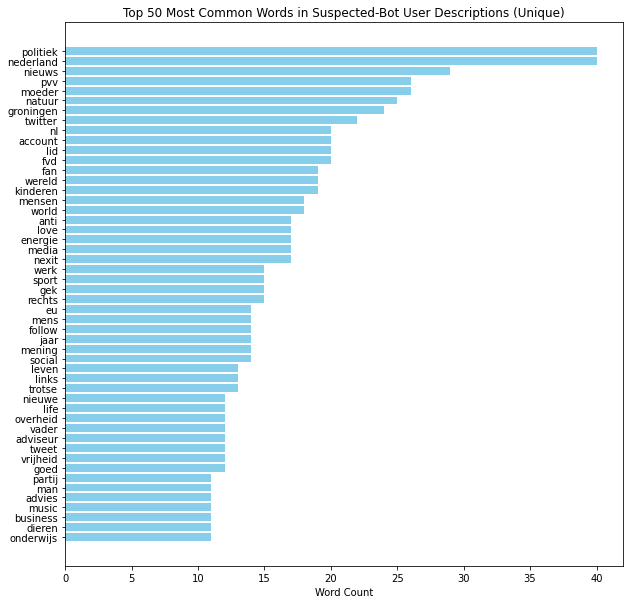

In [7]:
# Create a specific variable for this code containing the data needed
bot_descriptions_words = gaswinning.loc[gaswinning['BOT'] == True, ['user.id', 'user.description']].dropna(subset=["user.description"])

# Define a function that pre-processes the text before keyword analysis
def preprocess_text(text):
    # Remove the URL's 
    text = re.sub(r"http\S+", " ", text) 
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
     # Remove non-alphanumeric characters
    text = re.sub(r"[^\w\s]", " ", text.lower())
    
    words = [word for word in text.split() if word not in all_stop_words and len(word) >= 2]
    return " ".join(words)

# Create a list of political_party_abbreviations since they got filtered out by mistake in the PoS tags but can serve important information
political_party_abbreviations = ["pvv", "vvd", "cda", "d66", "gl", "sp", "pvda", "cu", "sgp", "fvd", "pvdd", "denk", "50plus"]

# Function to filter out specific types of words based on Part-of-Speech tags
def filter_pos_tags(text):
    doc = nlp(text)
    filtered_words = [
        token.text for token in doc 
        if (token.pos_ not in {"PRON", "DET", "AUX", "CCONJ", "PART", "INTJ", "VERB", "ADV", "IN", "RB", "ADP"} or token.text in political_party_abbreviations)          and token.text not in all_stop_words
        and len(token.text) >= 2
    ]
    return " ".join(filtered_words)

# Use the pre-processing function
bot_descriptions_words['user.description'] = bot_descriptions_words['user.description'].apply(preprocess_text)
descriptions = bot_descriptions_words.drop_duplicates(subset=["user.id", "user.description"]).reset_index(drop=True)

# Filter out the Part-of-Speech tags
descriptions['user.description'] = descriptions['user.description'].apply(filter_pos_tags)

# Function to filter out previously seen words per user
def filter_seen_words_per_user(df):
    for user in df['user.id'].unique():
        # For every user create a list of all descriptions they have used
        user_descriptions = df[df['user.id'] == user]['user.description'].tolist()
        # Create a seen_words set and filtered_descriptions
        seen_words = set()
        filtered_descriptions = []
        for desc in user_descriptions:
            # For every unique description a user has:
            # Create a set of words in the descriptions
            current_words = set(desc.split())
            # create a variable called new_words, which looks at the current 
            # words and remove the words which are in seen_words
            new_words = current_words - seen_words
            # every word which was not in seen_words yet gets added to it
            seen_words.update(current_words)
            # add the filtered_descriptions with all unique words in all descriptions
            filtered_descriptions.append(" ".join(new_words))
        # change the user.descriptions to filtered_descriptions, which is a list of every unique word in all different description per user
        df.loc[df['user.id'] == user, 'user.description'] = filtered_descriptions
    return df

# Use the filter_seen words function
descriptions = filter_seen_words_per_user(descriptions)
# Drop empty descriptions
descriptions = descriptions.dropna(subset=['user.description']).reset_index(drop=True)

# Count the occurrences of each word across all users
word_counter = Counter()
for desc in descriptions['user.description']:
    word_counter.update(desc.split())

# Get the 50 most common words
most_common_words = word_counter.most_common(50)

# Visualize the top 50 words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 10))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Word Count')
plt.title('Top 50 Most Common Words in Suspected-Bot User Descriptions (Unique)')
plt.gca().invert_yaxis()
plt.savefig('keywords_bot_descriptions.png', bbox_inches='tight')
plt.show()

In [8]:
# Print out with the counts to check since it is clearer than the visualization
most_common_words

[('politiek', 40),
 ('nederland', 40),
 ('nieuws', 29),
 ('pvv', 26),
 ('moeder', 26),
 ('natuur', 25),
 ('groningen', 24),
 ('twitter', 22),
 ('nl', 20),
 ('account', 20),
 ('lid', 20),
 ('fvd', 20),
 ('fan', 19),
 ('wereld', 19),
 ('kinderen', 19),
 ('mensen', 18),
 ('world', 18),
 ('anti', 17),
 ('love', 17),
 ('energie', 17),
 ('media', 17),
 ('nexit', 17),
 ('werk', 15),
 ('sport', 15),
 ('gek', 15),
 ('rechts', 15),
 ('eu', 14),
 ('mens', 14),
 ('follow', 14),
 ('jaar', 14),
 ('mening', 14),
 ('social', 14),
 ('leven', 13),
 ('links', 13),
 ('trotse', 13),
 ('nieuwe', 12),
 ('life', 12),
 ('overheid', 12),
 ('vader', 12),
 ('adviseur', 12),
 ('tweet', 12),
 ('vrijheid', 12),
 ('goed', 12),
 ('partij', 11),
 ('man', 11),
 ('advies', 11),
 ('music', 11),
 ('business', 11),
 ('dieren', 11),
 ('onderwijs', 11)]

### Count of bots with a description versus not, and a count of how many posts were made by bots with a description

In [9]:
# Create a specific variable for this code containing the data needed
bot_desc = gaswinning.loc[gaswinning['BOT'] == True, ['user.id', 'user.description']]

# Count the number of rows with and without descriptions
row_counts = bot_desc['user.description'].notna().value_counts().reset_index()
row_counts.columns = ['has_description', 'count']
row_counts['description_status'] = row_counts['has_description'].map({True: 'Has Description', False: 'No Description'})
row_counts = row_counts[['description_status', 'count']]

# Calculate percentages
total_rows = row_counts['count'].sum()
row_counts['percentage'] = (row_counts['count'] / total_rows) * 100

# Ensure that user.screen_name with descriptions and without descriptions are correctly categorized
user_descriptions = bot_desc.groupby('user.id')['user.description'].apply(lambda x: x.notna().any()).reset_index()
user_descriptions.columns = ['user.id', 'has_description']

# Categorize users based on their description status
user_descriptions['description_status'] = user_descriptions['has_description'].map({True: 'Has Description', False: 'No Description'})

# Count the number of unique users with and without descriptions
user_counts = user_descriptions['description_status'].value_counts().reset_index()
user_counts.columns = ['description_status', 'count']

# Calculate percentages
total_users = user_counts['count'].sum()
user_counts['percentage'] = (user_counts['count'] / total_users) * 100

# Show the results
print(f"Total tweet objects where the user has a description")
print(row_counts)
print("\nSuspected-bot accounts that have a description or not")
print(user_counts)

Total tweet objects where the user has a description
  description_status  count  percentage
0    Has Description   3045   61.218335
1     No Description   1929   38.781665

Suspected-bot accounts that have a description or not
  description_status  count  percentage
0    Has Description   1041   64.140481
1     No Description    582   35.859519
